In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import ratmetab
import itertools
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if os.getlogin() == 'jonesa7':
    codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
    datapath = {
        'blood new': 'blood_27_Oct_2022',
        'brain new': 'brain_27_Oct_2022',
        'blood old': 'old_blood_17_Nov_2022',
        'brain old': 'old_brain_17_Nov_2022',
               }
    data = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True) for k, v in datapath.items()}
else:
    datapath_blood = 'some/path'
    datapath_brain = 'some/path'
    codebookpath = 'some/path'

data.update({tissue: pd.concat([data[tissue + ' new'], data[tissue + ' old']], axis=0, join='outer') for tissue in ['blood', 'brain']})

def insert_centered_LIscore(dataset, data=data):
    df = data[dataset]
    s = df.LIscore - df.LIscore.mean()
    val = pd.concat([pd.DataFrame({'LIscore cent.': s}, index=df.index), df], axis=1)
    return(val)

def insert_age(dataset, data=data):
    df = data[dataset]
    l = [(lambda g: 'Y' if g == 'Y' else 'A')(group) for group in df.Group]
    val = pd.concat([pd.DataFrame({'Age': l}, index=df.index), df], axis=1)
    return(val)

data = {dataset: insert_age(dataset, data=data) for dataset in data.keys()}
data = {dataset: insert_centered_LIscore(dataset, data=data) for dataset in data.keys()}

In [3]:
codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')

In [4]:
#fm4 = 'Level ~ Age + Age : Q("LIscore cent.")'
fm4 = 'Level ~ C(Age, levels=["Y", "A"]) + Age : Q("LIscore cent.")'
fm5 = 'Level ~ C(Age, levels=["Y", "A"]) * Q("LIscore cent.")'

def fit_aclass_data(aclass, formula, dat=data['blood'], codebook=codebook):
    aclass_metabolites = codebook.loc[codebook.AnalyteClass == aclass].index
    sel_metabolites = list(set(dat.columns).intersection(set(aclass_metabolites)))
    sel_cols = ['LIscore cent.', 'Age'] + sel_metabolites
    df = dat.loc[:, sel_metabolites]
    # standardization
    df = df.apply(lambda x: (x - df.mean(axis=0)) / df.std(axis=0), axis=1)
    df = df.stack(dropna=False).to_frame('Level')
    df['Age'] = np.repeat(dat.Age, len(sel_metabolites)).to_list()
    df['LIscore cent.'] = np.repeat(dat['LIscore cent.'], len(sel_metabolites)).to_list()
    df['Metabolite'] = df.index.get_level_values(1)
    df = df.dropna()
    fmod = smf.mixedlm(formula, data=df, groups='Metabolite').fit()
    return(fmod)

def extract_fit_info(fmod, aclass):
    fmod.summary()
    d = {'Estimate': fmod.params, 'SE': fmod.bse, 'p': fmod.pvalues}
    ll = [a.to_list() for a in d.values()]
    l = itertools.chain(*ll)
    ix = pd.MultiIndex.from_product([d.keys(), d['Estimate'].index])
    df = pd.DataFrame({aclass: l}, index=ix).transpose()
    df[('General', 'Converged')] = fmod.converged
    return(df)

def process_aclass(aclass, formula, dat=data['blood'], codebook=codebook):
    fmod = fit_aclass_data(aclass, formula, dat=dat, codebook=codebook)
    df = extract_fit_info(fmod, aclass)
    return(df)

In [5]:
l = [process_aclass(aclass, fm4) for aclass in np.unique(codebook.AnalyteClass)]
results_m4 = pd.concat(l, axis=0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

In [6]:
results_m4

Estimate                                 \
                                    Intercept C(Age, levels=["Y", "A"])[T.A]   
Acylcarnitines                   6.858783e-17                       0.019646   
Amino_Acids_and_Biogenic_Amines -4.984035e-17                      -0.010743   
Bile_Acids                      -6.605985e-02                       0.114752   
Ceramides                       -5.420327e-01                       0.797486   
Free_Fatty_Acids                 7.511543e-16                       0.203263   
Free_Oxysterols                 -3.977461e-01                       0.640660   
Hexoses                          5.768940e-01                      -0.864633   
Lysophosphatidylcholines         2.083574e-15                       0.443270   
Phosphatidylcholines            -7.147022e-01                       1.082648   
Phosphatidylethanolamines        1.987088e-15                       0.650757   
Phosphatidylglycerols           -4.157804e-01                       0.544424   
Phosphatidylserines             -1.998570e-01                       0.309815   
Sphingomyelins                  -5.794983e-01                       0.849524   

                                                           \
                                Age[A]:Q("LIscore cent.")   
Acylcarnitines                                   0.002192   
Amino_Acids_and_Biogenic_Amines                  0.000835   
Bile_Acids                                      -0.000489   
Ceramides                                       -0.001683   
Free_Fatty_Acids                                -0.000334   
Free_Oxysterols                                 -0.003698   
Hexoses                                          0.000420   
Lysophosphatidylcholines                        -0.001410   
Phosphatidylcholines                            -0.001229   
Phosphatidylethanolamines                        0.001183   
Phosphatidylglycerols                            0.003150   
Phosphatidylserines                              0.000609   
Sphingomyelins                                   0.001840   

                                                                          \
                                Age[Y]:Q("LIscore cent.") Metabolite Var   
Acylcarnitines                                   0.001229   0.000000e+00   
Amino_Acids_and_Biogenic_Amines                 -0.000813   0.000000e+00   
Bile_Acids                                       0.000900   6.559931e-05   
Ceramides                                       -0.001107   1.013036e-10   
Free_Fatty_Acids                                 0.001081   0.000000e+00   
Free_Oxysterols                                 -0.000068   5.599380e-05   
Hexoses                                          0.000485   1.000000e+00   
Lysophosphatidylcholines                         0.001310   0.000000e+00   
Phosphatidylcholines                             0.000354   5.177766e-05   
Phosphatidylethanolamines                       -0.000783   0.000000e+00   
Phosphatidylglycerols                           -0.000385   1.679678e-03   
Phosphatidylserines                              0.002299   1.330368e-06   
Sphingomyelins                                  -0.000109   7.898234e-07   

                                           SE                                 \
                                    Intercept C(Age, levels=["Y", "A"])[T.A]   
Acylcarnitines                   1.038866e+06                       0.073588   
Amino_Acids_and_Biogenic_Amines  5.388829e+05                       0.044073   
Bile_Acids                       5.131444e-02                       0.061686   
Ceramides                        3.950055e-02                       0.046794   
Free_Fatty_Acids                 7.458616e+05                       0.054789   
Free_Oxysterols                  4.996154e-02                       0.060128   
Hexoses                          9.560794e-01                       0.245114   
Lysophosphatidylcholines         8.427543e+05              

In [7]:
def plot_param(param='Age[A]:Q("LIscore cent.")', results=results_m4, model='Mixed M4'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    yticks = np.arange(results.shape[0])
    Estimate = results[('Estimate', param)]
    SE = results[('SE', param)]
    converged = results_m4[('General', 'Converged')]
    color = converged.apply(lambda b: 'C0' if b else 'red')
    handles = [mpatches.Patch(color=c) for c in ['C0', 'red']]
    labels = ['yes', 'no']
    fig.legend(handles, labels, title='Converged?', loc='center', bbox_to_anchor=(0.51, 0.85))
    ax[0].barh(yticks, Estimate, xerr=SE, color=color)
    ax[0].set_yticks(yticks)
    ax[0].set_yticklabels(results.index)
    ax[0].set_title('Estimates')
    ax[0].grid(axis='both')
    pval = results[('p', param)]
    ax[1].scatter(x=pval, y=yticks, c=color)
    ax[1].grid(axis='both')
    ax[1].set_title('p-values')
    ax[1].set_xscale('log')
    fig.suptitle(model + ' parameter: ' + param)
    return((fig, ax))

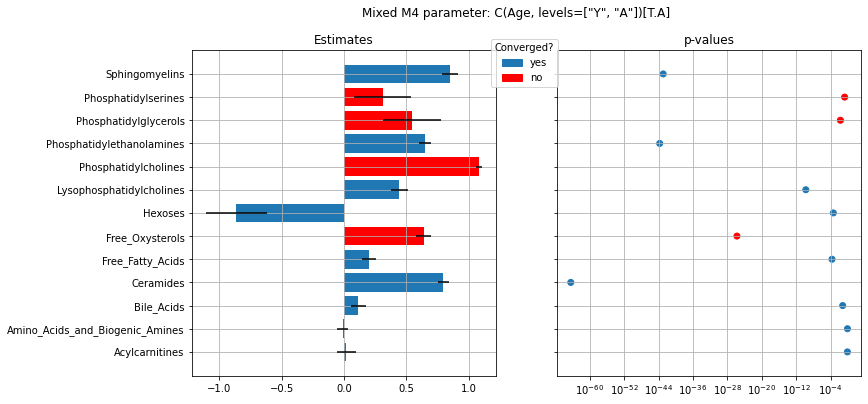

In [12]:
fig, ax = plot_param(param='C(Age, levels=["Y", "A"])[T.A]', results=results_m4, model='Mixed M4')

(5e-08, 1)

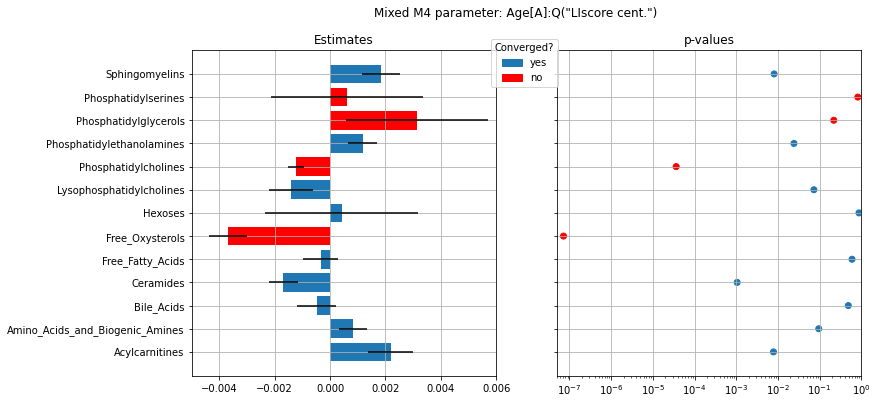

In [13]:
fig, ax = plot_param(param='Age[A]:Q("LIscore cent.")', results=results_m4, model='Mixed M4')
ax[0].set_xlim(-0.005, 0.006)
ax[1].set_xlim(5e-8, 1)

(5e-08, 1)

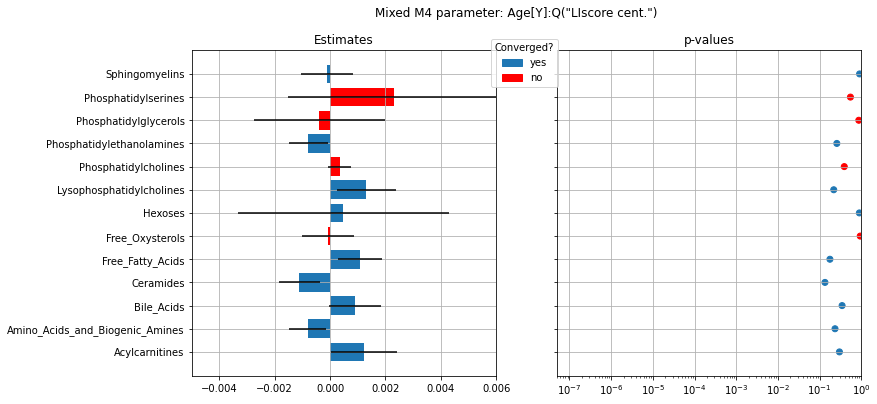

In [14]:
fig, ax = plot_param(param='Age[Y]:Q("LIscore cent.")', results=results_m4, model='Mixed M4')
ax[0].set_xlim(-0.005, 0.006)
ax[1].set_xlim(5e-8, 1)

In [10]:
%connect_info

{
  "shell_port": 52374,
  "iopub_port": 52375,
  "stdin_port": 52376,
  "control_port": 52378,
  "hb_port": 52377,
  "ip": "127.0.0.1",
  "key": "cbf70d28-80b48bb60673b495a054b3f1",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-2bbdf49d-ea41-413d-806a-0f8c20633b76.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
